# Google drive

In [ ]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/fruit-and-vegetable-image-recognition'

# Get the absolute path of the train folder
abspath_train = '/content/drive/My Drive/fruit-and-vegetable-image-recognition/train/'

# Get the absolute path of the test folder
abspath_test = '/content/drive/My Drive/fruit-and-vegetable-image-recognition/test/'

# Get the absolute path of the test folder
abspath_validation = '/content/drive/My Drive/fruit-and-vegetable-image-recognition/validation/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Download and loading Fruits and Vegetables Image Recognition dataset

In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

# Create a list with the filepaths for training and testing
train_dir = Path('/content/drive/My Drive/fruit-and-vegetable-image-recognition/train/')
traindata = tf.keras.preprocessing.image_dataset_from_directory(train_dir)
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('/content/drive/My Drive/fruit-and-vegetable-image-recognition/test/')
testdata = tf.keras.preprocessing.image_dataset_from_directory(test_dir)
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('/content/drive/My Drive/fruit-and-vegetable-image-recognition/validation/')
valdata = tf.keras.preprocessing.image_dataset_from_directory(val_dir)
val_filepaths = list(test_dir.glob(r'**/*.jpg'))


Found 3115 files belonging to 36 classes.
Found 359 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.15,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(299, 299))


validation_generator = train_datagen.flow_from_directory(val_dir,
                                                         batch_size=32,
                                                         class_mode='categorical',
                                                         target_size=(299, 299))


test_generator = train_datagen.flow_from_directory(test_dir,
                                                         batch_size=32,
                                                         class_mode='categorical',
                                                         target_size=(299, 299))

Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.
Found 359 images belonging to 36 classes.


# Create Model

In [ ]:
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D 
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras import metrics
from tensorflow.keras.optimizers import Adam 
from keras import backend as K
import keras


def conv_block(x, nb_filter, nb_row, nb_col, padding = "same", strides = (1, 1), use_bias = False):
    '''Defining a Convolution block that will be used throughout the network.'''
    
    x = Conv2D(nb_filter, (nb_row, nb_col), strides = strides, padding = padding, use_bias = use_bias)(x)
    x = BatchNormalization()(x)
    x = Activation("selu")(x)
    
    return x

def stem(input):
    '''The stem of the pure Inception-v4 and Inception-ResNet-v2 networks. This is input part of those networks.'''
    
    # Input shape is 299 * 299 * 3 (Tensorflow dimension ordering)
    x = conv_block(input, 32, 3, 3, strides = (2, 2), padding = "same") # 149 * 149 * 32
    x = conv_block(x, 32, 3, 3, padding = "same") # 147 * 147 * 32
    x = conv_block(x, 64, 3, 3) # 147 * 147 * 64

    x1 = MaxPooling2D((3, 3), strides = (2, 2), padding = "same")(x)
    x2 = conv_block(x, 96, 3, 3, strides = (2, 2), padding = "same")

    x = concatenate([x1, x2], axis = 3) # 73 * 73 * 160

    x1 = conv_block(x, 96, 1, 1)
    x1 = conv_block(x1, 96, 3, 3, padding = "same")

    x2 = conv_block(x, 64, 1, 1)
    x2 = conv_block(x2, 64, 1, 7)
    x2 = conv_block(x2, 64, 7, 1)
    x2 = conv_block(x2, 96, 3, 3, padding = "same")

    x = concatenate([x1, x2], axis = 3) # 71 * 71 * 192

    x1 = conv_block(x, 192, 3, 3, strides = 2, padding = "same")
    
    x2 = MaxPooling2D((3, 3), strides = (2, 2), padding = "same")(x)

    x = concatenate([x1, x2], axis = 3) # 35 * 35 * 384
    
    return x

def inception_A(input):
    '''Architecture of Inception_A block which is a 35 * 35 grid module.'''
    
    a1 = AveragePooling2D((3, 3), strides = (1, 1), padding = "same")(input)
    a1 = conv_block(a1, 96, 1, 1)
    
    a2 = conv_block(input, 96, 1, 1)
    
    a3 = conv_block(input, 64, 1, 1)
    a3 = conv_block(a3, 96, 3, 3)
    
    a4 = conv_block(input, 64, 1, 1)
    a4 = conv_block(a4, 96, 3, 3)
    a4 = conv_block(a4, 96, 3, 3)
    
    merged = concatenate([a1, a2, a3, a4], axis = -1)
    
    return merged

def inception_B(input):
    '''Architecture of Inception_B block which is a 17 * 17 grid module.'''
    
    b1 = AveragePooling2D((3, 3), strides = (1, 1), padding = "same")(input)
    b1 = conv_block(b1, 128, 1, 1)
    
    b2 = conv_block(input, 384, 1, 1)
    
    b3 = conv_block(input, 192, 1, 1)
    b3 = conv_block(b3, 224, 1, 7)
    b3 = conv_block(b3, 256, 7, 1)
    
    b4 = conv_block(input, 192, 1, 1)
    b4 = conv_block(b4, 192, 7, 1)
    b4 = conv_block(b4, 224, 1, 7)
    b4 = conv_block(b4, 224, 7, 1)
    b4 = conv_block(b4, 256, 1, 7)
    
    merged = concatenate([b1, b2, b3, b4], axis = -1)
    
    return merged

def inception_C(input):
    '''Architecture of Inception_C block which is a 8 * 8 grid module.'''
    
    c1 = AveragePooling2D((3, 3), strides = (1, 1), padding = "same")(input)
    c1 = conv_block(c1, 256, 1, 1)
    
    c2 = conv_block(input, 256, 1, 1)

    c3 = conv_block(input, 384, 1, 1)
    c31 = conv_block(c2, 256, 1, 3)
    c32 = conv_block(c2, 256, 3, 1)
    c3 = concatenate([c31, c32], axis = -1)

    c4 = conv_block(input, 384, 1, 1)
    c4 = conv_block(c3, 448, 3, 1)
    c4 = conv_block(c3, 512, 1, 3)
    c41 = conv_block(c3, 256, 1, 3)
    c42 = conv_block(c3, 256, 3, 1)
    c4 = concatenate([c41, c42], axis = -1)
  
    merged = concatenate([c1, c2, c3, c4], axis = -1)
    
    return merged

def reduction_A(input, k = 192, l = 224, m = 256, n = 384):
    '''Architecture of a 35 * 35 to 17 * 17 Reduction_A block.'''

    ra1 = MaxPooling2D((3, 3), strides = (2, 2), padding = "same")(input)
    
    ra2 = conv_block(input, n, 3, 3, strides = (2, 2), padding = "same")

    ra3 = conv_block(input, k, 1, 1)
    ra3 = conv_block(ra3, l, 3, 3)
    ra3 = conv_block(ra3, m, 3, 3, strides = (2, 2), padding = "same")

    merged = concatenate([ra1, ra2, ra3], axis = -1)
    
    return merged

def reduction_B(input):
    '''Architecture of a 17 * 17 to 8 * 8 Reduction_B block.'''
    
    rb1 = MaxPooling2D((3, 3), strides = (2, 2), padding = "same")(input)
    
    rb2 = conv_block(input, 192, 1, 1)
    rb2 = conv_block(rb2, 192, 3, 3, strides = (2, 2), padding = "same")
    
    rb3 = conv_block(input, 256, 1, 1)
    rb3 = conv_block(rb3, 256, 1, 7)
    rb3 = conv_block(rb3, 320, 7, 1)
    rb3 = conv_block(rb3, 320, 3, 3, strides = (2, 2), padding = "same")
    
    merged = concatenate([rb1, rb2, rb3], axis = -1)
    
    return merged

def inception_v4(nb_classes = 1001, load_weights = True):
    '''Creates the Inception_v4 network.'''
    
    init = Input((299, 299, 3)) # Channels last, as using Tensorflow backend with Tensorflow image dimension ordering
    
    x = stem(init) # Output: 35 * 35 * 384
    
    # 4 x Inception A
    for i in range(4):
        x = inception_A(x)
        # Output: 35 * 35 * 384
        
    # Reduction A
    x = reduction_A(x, k = 192, l = 224, m = 256, n = 384) # Output: 17 * 17 * 1024

    # 7 x Inception B
    for i in range(7):
        x = inception_B(x)
        # Output: 17 * 17 * 1024
        
    # Reduction B
    x = reduction_B(x) # Output: 8 * 8 * 1536

    # 3 x Inception C
    for i in range(3):
        x = inception_C(x) 
        # Output: 8 * 8 * 1536
        
    # Average Pooling
    x = AveragePooling2D((8, 8))(x) # Output: 1536

    # Dropout
    x = Dropout(0.2)(x) # Keep dropout 0.2 as mentioned in the paper
    x = Flatten()(x) # Output: 1536

    # Output layer
    output = Dense(units = nb_classes, activation = "softmax")(x) # Output: 1000

    model = Model(init, output, name = "Inception-v4")   
        
    return model

## Compile model

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# keras.backend.clear_session()
model=inception_v4(nb_classes = 36, load_weights = True)

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.00001), metrics=['accuracy']) #binary_crossentropy
# model.compile(loss='categorical_crossentropy', optimizer=Adam(lr = 0.0001), metrics=['accuracy'])

model.summary()

Model: "Inception-v4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 150, 150, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


 activation_2 (Activation)      (None, 150, 150, 64  0           ['batch_normalization_2[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 75, 75, 96)   55296       ['activation_2[0][0]']           
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 75, 75, 96)  384         ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 75, 75, 64)   0           ['activation_2[0][0]']           
                                                                                                  
 activatio

# Train Model

In [ ]:
import os

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size
epochs = 20

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# split and shuffle data 
#np.random.seed(2018)
#indexes = np.arange(train_dataset_info.shape[0])
#np.random.shuffle(indexes)
#train_indexes = indexes[:27500]
#valid_indexes = indexes[27500:]
model.load_weights('inceptionv4_weights_80epochs.h5')

# train model

history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps = STEP_SIZE_VALID,
    epochs=epochs, 
    verbose=1,
    callbacks=[cp_callback]
    )

Epoch 1/20
 2/97 [..............................] - ETA: 3:31 - loss: 0.3829 - accuracy: 0.8594   

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


39/97 [===========>..................] - ETA: 10:44 - loss: 0.3781 - accuracy: 0.8694

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


97/97 [==============================] - ETA: 0s - loss: 0.3660 - accuracy: 0.8787 
Epoch 1: saving model to training_1/cp.ckpt
97/97 [==============================] - 1234s 12s/step - loss: 0.3660 - accuracy: 0.8787 - val_loss: 0.2956 - val_accuracy: 0.9156
Epoch 2/20
97/97 [==============================] - ETA: 0s - loss: 0.3415 - accuracy: 0.8865
Epoch 2: saving model to training_1/cp.ckpt
97/97 [==============================] - 303s 3s/step - loss: 0.3415 - accuracy: 0.8865 - val_loss: 0.2729 - val_accuracy: 0.9344
Epoch 3/20
97/97 [==============================] - ETA: 0s - loss: 0.3388 - accuracy: 0.8793
Epoch 3: saving model to training_1/cp.ckpt
97/97 [==============================] - 302s 3s/step - loss: 0.3388 - accuracy: 0.8793 - val_loss: 0.2610 - val_accuracy: 0.9187
Epoch 4/20
97/97 [==============================] - ETA: 0s - loss: 0.3221 - accuracy: 0.8943
Epoch 4: saving model to training_1/cp.ckpt
97/97 [==============================] - 306s 3s/step - loss: 0.32

In [ ]:
model.save('inceptionv4.h5', overwrite=True)
model.save_weights('inceptionv4_weights.h5', overwrite=True)

# Visualization

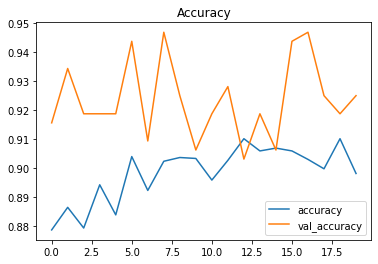

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

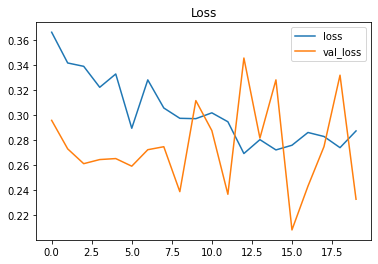

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# Test Accuracy

In [ ]:
loss, accuracy = model.evaluate(test_generator)

 5/12 [===========>..................] - ETA: 22s - loss: 0.1773 - accuracy: 0.9500

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


12/12 [==============================] - 31s 2s/step - loss: 0.1989 - accuracy: 0.9387
